## Contents
* [Load Sets](#load_sets)
* [Factorizing data and creating probability vectors](#FD)
* [Getting the Features and the targets for each set](#GF)
* [Normalizing Data](#ND)
* [Class Balance](#CB)
* [Model](#Model)
* [Submission File](#Submission_File)

<a id="load_sets"></a>
## Load Sets

In [1]:
# mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

# loading the datasets with pandas
train = pd.read_pickle('/content/drive/MyDrive/Data/H&M_project/train.pkl', compression='gzip')
val = pd.read_pickle('/content/drive/MyDrive/Data/H&M_project/val.pkl', compression='gzip')
test = pd.read_pickle('/content/drive/MyDrive/Data/H&M_project/test.pkl', compression='gzip')
train_all = pd.read_pickle('/content/drive/MyDrive/Data/H&M_project/train_all.pkl', compression='gzip')


<a id="FD"></a>

## Factorizing data and creating probability vectors

In [3]:
import numpy as np
# preprocessing the created data
def process_data(data):

  # gettig the mean price of the items that every customer bought
  data['mean_price'] = data['price'].apply(lambda x: np.mean(x))

  # dropping unesessary columns
  data = data.drop(['sales_channel_id', 'price', 'article_id'], axis=1)

  # factorizing all categorical columns
  data_processed = data.copy()
  data_processed['club_member_status'] = pd.factorize(data_processed['club_member_status'])[0]
  data_processed['fashion_news_frequency'] = pd.factorize(data_processed['fashion_news_frequency'])[0]
  data_processed['postal_code'] = pd.factorize(data_processed['postal_code'])[0]

  return data_processed


train_processed = process_data(train)
val_processed = process_data(val)
test_processed = process_data(test)
train_all = process_data(train_all)

In [4]:
from collections import Counter

# Creating class for each customer by getting the cluster from which they have
# bought the most times
def create_prob_vecs(data, cluster_count):
    classes = []

    for item_classes in data['item_class'].to_list():

        # if customer has a history then create a prob vector
        if isinstance(item_classes, list):
            customer_history = dict(Counter(item_classes))
            prob_vector = np.zeros(cluster_count)

            cluster_indices = list(customer_history.keys())
            cluster_counts = np.array(list(customer_history.values()))

            prob_vector[cluster_indices] = cluster_counts
            prob_vector /= len(customer_history)

            classes.append(np.argmax(prob_vector))

        # if customer has not bought anything then assign a zero prob vector
        # this assigns a class of zero (which does not correspond to a cluster)
        else:
            prob_vector = np.zeros(cluster_count)
            classes.append(np.argmax(prob_vector))

    return classes

cluster_count = 304
train_processed['class'] = create_prob_vecs(train_processed, cluster_count)
val_processed['class'] = create_prob_vecs(val_processed, cluster_count)
test_processed['class'] = create_prob_vecs(test_processed, cluster_count)
train_all['class'] = create_prob_vecs(train_all, cluster_count)

<a id="GF"></a>
## Getting the Features and the targets for each set

In [5]:
X_train = train_processed[['club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 'mean_price']].to_numpy()
y_train = train_processed['class'].to_numpy()

X_val = val_processed[['club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 'mean_price']].to_numpy()
y_val = val_processed['class'].to_numpy()

X_test = test_processed[['club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 'mean_price']].to_numpy()
y_test = test_processed['class'].to_numpy()


# setting the mean prices of nan with 0
train_all['mean_price'] = train_all['mean_price'].fillna(0)

X = train_all[['club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 'mean_price']].to_numpy()
y = train_all['class'].to_numpy()


In [6]:
# printing the shapes
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(1333465, 5) (1333465,)
(249511, 5) (249511,)
(75481, 5) (75481,)


<a id="ND"></a>
## Normalizing Data

In [7]:
from sklearn.preprocessing import MinMaxScaler

# Creating an instance of MinMaxScaler
scaler = MinMaxScaler()

# Fitting the scaler to the training data
scaler.fit(X_train)

# Normalizing the data

X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

all_data_scaler = MinMaxScaler()
X = all_data_scaler.fit_transform(X)

<a id="CB"></a>

## Class Balance

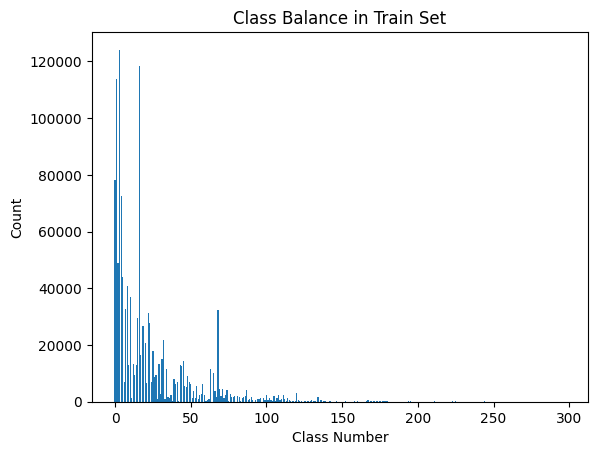

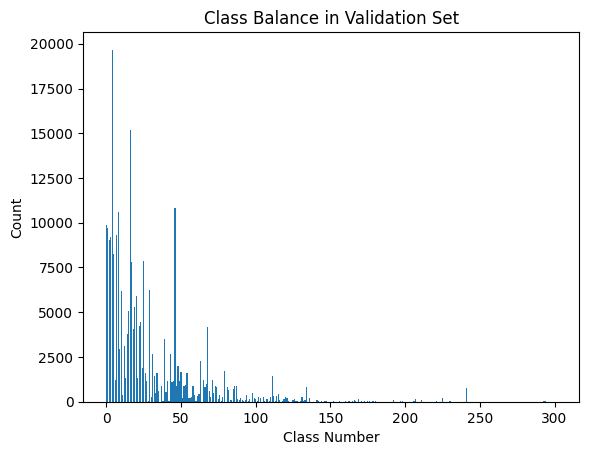

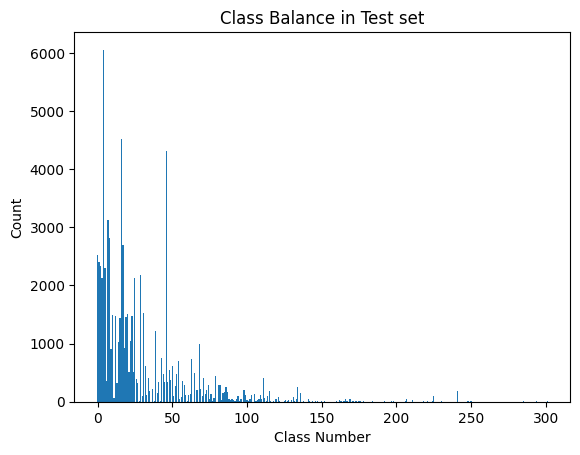

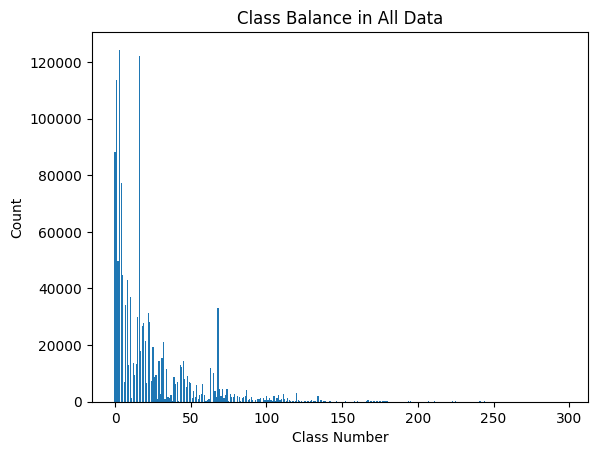

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def class_balance(y, set_type):
  # Counting the occurrences of each class
  class_counts = np.bincount(y)

  # Creating x-axis values (class numbers)
  class_numbers = np.arange(len(class_counts))

  # Creating a bar plot
  plt.bar(class_numbers, class_counts)
  plt.xlabel('Class Number')
  plt.ylabel('Count')
  plt.title(f'Class Balance in {set_type}')
  plt.savefig(f'balance_{set_type}.png', bbox_inches='tight')
  plt.show()


class_balance(y_train, 'Train Set')
class_balance(y_val, 'Validation Set')
class_balance(y_test, 'Test set')
class_balance(y, 'All Data')


It seems that some classes do not have a high probability of occuring, therefore we can drop the samples that classify to those classes, try to balance the dataset and then train the model on it ( this has to happen only on the training set )

In [9]:
def cut_y(y_train):
  # Counting the occurrences of each class
  class_counts = pd.DataFrame(y_train)[0].value_counts()

  # getting the classes that occur more than 10000 times
  new_classes = [i for i in pd.DataFrame(class_counts[class_counts > 10000].index)[0].unique()]

  # filtering y_train
  y_train = pd.DataFrame(y_train)
  y_train_new_df = y_train[y_train[0].isin(new_classes)]
  y_train_new = y_train_new_df[0].to_numpy()

  return y_train_new, y_train_new_df

y_train_new, y_train_new_df = cut_y(y_train)

# doing the same for y
y_new, y_new_df = cut_y(y)

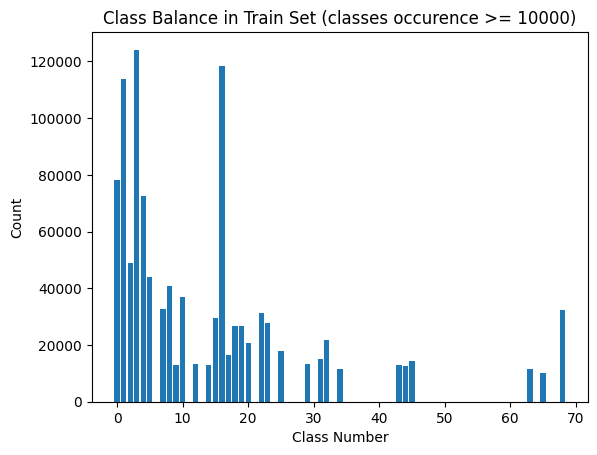

In [10]:
class_balance(y_train_new, 'Train Set (classes occurence >= 10000)')

In [11]:
# filtering the same samples from X
def cut_X(X_train, y_train_new_df):
  X_train_df = pd.DataFrame(X_train)
  X_train_df = X_train_df[X_train_df.index.isin(y_train_new_df.index)]

  X_train_norm_new = X_train_df.to_numpy()

  return X_train_norm_new

X_train_norm_new = cut_X(X_train, y_train_new_df)

X_new = cut_X(X, y_new_df)

In [12]:
X_train_norm_new.shape, y_train_new.shape

((1101678, 5), (1101678,))

In [13]:
X_new.shape, y_new.shape

((1134326, 5), (1134326,))

In [14]:
from imblearn.over_sampling import SMOTE

# Instantiating SMOTE
smote = SMOTE(k_neighbors=2)

# Performing SMOTE oversampling
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_norm_new, y_train_new)
X_resampled, y_resampled = smote.fit_resample(X_new, y_new)


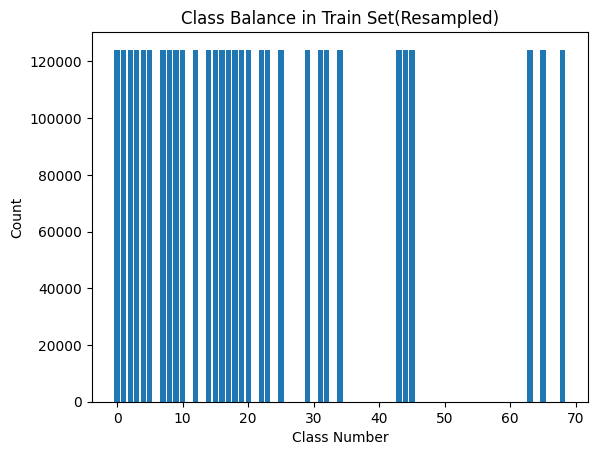

In [15]:
class_balance(y_train_resampled, 'Train Set(Resampled)')

SMOTE created too many examples. Getting less examples but keeping the balance is good idea for not consuming all the ram

In [16]:
X_train_resampled.shape, y_train_resampled.shape

((3848526, 5), (3848526,))

In [17]:
X_resampled.shape, y_resampled.shape

((3854943, 5), (3854943,))

In [18]:
from sklearn.model_selection import train_test_split

# Split the dataset into train and test sets, maintaining class balance
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.995, stratify=y_train_resampled
)

X_train_sample.shape, y_train_sample.shape

((19242, 5), (19242,))

In [19]:
X_sample, _, y_sample, _ = train_test_split(
    X_resampled, y_resampled, test_size=0.7, stratify=y_resampled
)

X_sample.shape, y_sample.shape

((1156482, 5), (1156482,))

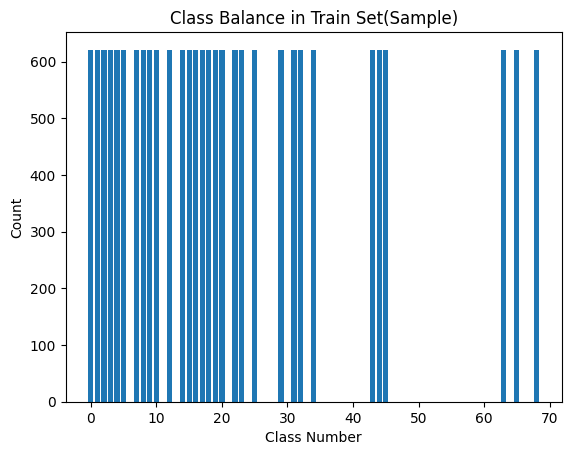

In [20]:
class_balance(y_train_sample, 'Train Set(Sample)')

<a id="Model"></a>
## Model

### Creating and Training the model

#### Balanced Classes

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
import time
from tqdm import tqdm

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    LogisticRegression(),
    LGBMClassifier(),
    LinearDiscriminantAnalysis(),
]


k = 5  # Number of folds for cross-validation

for classifier in classifiers:
    scores = cross_val_score(classifier, X_train_sample, y_train_sample, cv=k, scoring='accuracy')
    avg_score = scores.mean()

    print(f"Classifier: {classifier.__class__.__name__}")
    print(f"Cross-validated accuracy: {avg_score:.4f}")


    # Start the timer
    start_time = time.time()

    # Train the classifier on the training set
    classifier.fit(X_train_sample, y_train_sample)

    # Calculate the training time
    training_time = time.time() - start_time

    # Evaluate on the validation set
    val_score = classifier.score(X_val, y_val)
    print(f"Validation accuracy: {val_score:.4f}")
    print(f'Training Time: {training_time}')
    print()


Classifier: KNeighborsClassifier
Cross-validated accuracy: 0.0391
Validation accuracy: 0.0329
Training Time: 0.01380014419555664

Classifier: DecisionTreeClassifier
Cross-validated accuracy: 0.0519
Validation accuracy: 0.0382
Training Time: 0.17467498779296875

Classifier: LogisticRegression
Cross-validated accuracy: 0.0323
Validation accuracy: 0.0608
Training Time: 0.13886761665344238

Classifier: LGBMClassifier
Cross-validated accuracy: 0.0719
Validation accuracy: 0.0591
Training Time: 4.124648332595825

Classifier: LinearDiscriminantAnalysis
Cross-validated accuracy: 0.0598
Validation accuracy: 0.0324
Training Time: 0.02498030662536621



#### Original Balance in Classes

In [23]:
# sampling the dataset due to the volume of the data
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train_norm_new, y_train_new, test_size=0.98, stratify=y_train_new
)

X_train_sample.shape, y_train_sample.shape

((22033, 5), (22033,))

In [24]:

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    LogisticRegression(),
    LGBMClassifier(),
    LinearDiscriminantAnalysis(),
]


k = 5  # Number of folds for cross-validation

for classifier in classifiers:
    scores = cross_val_score(classifier, X_train_sample, y_train_sample, cv=k, scoring='accuracy')
    avg_score = scores.mean()

    print(f"Classifier: {classifier.__class__.__name__}")
    print(f"Cross-validated accuracy: {avg_score:.4f}")

    # Start the timer
    start_time = time.time()

    # Train the classifier on the training set
    classifier.fit(X_train_sample, y_train_sample)

    # Calculate the training time
    training_time = time.time() - start_time

   # Evaluate on the validation set
    val_score = classifier.score(X_val, y_val)
    print(f"Validation accuracy: {val_score:.4f}")
    print(f'Training Time: {training_time}')
    print()


Classifier: KNeighborsClassifier
Cross-validated accuracy: 0.0845
Validation accuracy: 0.0414
Training Time: 0.016176700592041016

Classifier: DecisionTreeClassifier
Cross-validated accuracy: 0.0709
Validation accuracy: 0.0452
Training Time: 0.13652968406677246

Classifier: LogisticRegression
Cross-validated accuracy: 0.1126
Validation accuracy: 0.0581
Training Time: 1.2924304008483887

Classifier: LGBMClassifier
Cross-validated accuracy: 0.1220
Validation accuracy: 0.0754
Training Time: 5.788863182067871

Classifier: LinearDiscriminantAnalysis
Cross-validated accuracy: 0.1396
Validation accuracy: 0.0738
Training Time: 0.02567148208618164



In [27]:
from sklearn.metrics import classification_report

# Creating a LGBM classifier object
lgbm = LGBMClassifier()

# Start the timer
start_time = time.time()

# Training the classifier on the training data
lgbm.fit(X_train_norm_new, y_train_new)

# Calculate the training time
training_time = time.time() - start_time

# Making predictions on the test data
y_pred = lgbm.predict(X_test)

# Evaluating the classifier
report = classification_report(y_test, y_pred)
print(report)
print(f'Training Time: {training_time}')
print()


              precision    recall  f1-score   support

           0       0.06      0.05      0.06      2518
           1       0.04      0.12      0.06      2407
           2       0.05      0.00      0.00      2341
           3       0.05      0.41      0.09      2131
           4       0.15      0.51      0.23      6056
           5       0.09      0.05      0.06      2309
           6       0.00      0.00      0.00       352
           7       0.00      0.00      0.00      3129
           8       0.00      0.00      0.00      2812
           9       0.00      0.00      0.00       915
          10       0.06      0.00      0.00      1487
          11       0.00      0.00      0.00        58
          12       0.13      0.13      0.13      1483
          13       0.00      0.00      0.00       316
          14       0.10      0.00      0.01      1025
          15       0.05      0.00      0.01      1436
          16       0.10      0.52      0.17      4514
          17       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# calculating the results of the metrics
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

print(f'Accuracy : {acc:.4f}')
print(f'F1-Score : {f1:.4f}')
print(f'Recall : {recall:.4f}')
print(f'Precision : {precision:.4f}')

Accuracy : 0.0955
F1-Score : 0.0425
Recall : 0.0955
Precision : 0.0466


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Training on All The Data

In [31]:

# Creating a LGBM classifier object
lgbm = LGBMClassifier()

# Start the timer
start_time = time.time()

# Training the classifier on the training data
lgbm.fit(X_new, y_new)

# Calculate the training time
training_time = time.time() - start_time

print(f'Training Time: {training_time}')



Training Time: 85.69933247566223


In [34]:
y_pred = lgbm.predict(X) # making predictions on all the customers

<a id="Submission_File"></a>
## Submission File

In [35]:
import random
from sklearn.model_selection import cross_val_score

articles = pd.read_pickle('/content/drive/MyDrive/Data/H&M_project/articles.pkl', compression='gzip')

# Adding predictions to the test set
train_all['prediction_class'] = y_pred

# Getting all prediction classes' article IDs
pred_id = {}
for pred_class in train_all['prediction_class'].unique():
    pred_id[pred_class] = articles.loc[articles['class_label'] == pred_class, 'article_id'].tolist()

# Generating recommendations with progress bar
recom_ids = []
for pred_class in tqdm(train_all['prediction_class'], desc="Generating recommendations"):
    sampled_ids = random.sample(pred_id[pred_class], min(len(pred_id[pred_class]), 12))
    ids = ' '.join(map(str, sampled_ids))
    recom_ids.append(ids)

# Adding recommendations to the dataframe
train_all['prediction'] = recom_ids


Generating recommendations: 100%|██████████| 1371980/1371980 [00:11<00:00, 121541.65it/s]


In [36]:
sub_file = train_all[['customer_id', 'prediction']]

In [37]:
sub_file

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,632189004 548110018 573085055 607844002 898596...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,584915011 662696001 613347001 451380003 543827...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,839799002 766402022 808237001 584722001 800528...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,448515019 524825019 868115001 612455006 587677...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,722970002 772232001 596643001 907472002 687022...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,652377012 743932004 863560003 853391003 598604...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,351484012 536139046 714591001 485554009 485537...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,820866011 485689026 706837004 586551001 684272...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,811705004 828919003 837941001 769573001 688430...


In [38]:
# saving the submission file
sub_file.to_csv('submission.csv', index=False)